<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/2020-12/continuous_treatment_effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will investigate one question: **Does higher policy score lead to higher behavioral change in a county?**

# load R + python packages

In [1]:
cd drive/MyDrive/covid/PSM/data

/content/drive/MyDrive/covid/PSM/data


In [2]:
ls

agg_social_dist_2.csv
agg_social_dist.csv
avg_google_mobility_up_to_6_1.csv
avg_google_mobility_up_to_6_1_weekdays.csv
county_data_with_reduced_covariates_with_SIP.csv
data_with_policy_scores.csv
final_data_google_and_safe_graph_up_to_6_1.csv
final_data_google_and_safe_graph_up_to_6_1_weekdays.csv
final_policy_scores.csv
google_mobility.csv
policy_scores.csv
social_dist_aggregated_on_county.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%load_ext rpy2.ipython
# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
install.packages('stats')
install.packages('survey')

In [ ]:
%%R
library('stats')
library('survey')

# load data

In [7]:
data = pd.read_csv('data_with_policy_scores.csv')

In [8]:
data

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_at_home,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White,GovernmentResponseIndex
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,69.134839
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,69.134839
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,69.134839
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,69.134839
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,69.134839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56.0,WY,Wyoming,Sweetwater County,56037.0,-0.018485,0,73315.0,10.9,43051,-0.535382,26.2,12.1,1.0,1.1,16.1,79.3,66.658226
2991,56.0,WY,Wyoming,Teton County,56039.0,0.075183,1,99087.0,46.4,23081,0.278663,18.4,15.4,1.4,0.6,14.9,81.5,66.658226
2992,56.0,WY,Wyoming,Uinta County,56041.0,0.010157,0,63401.0,43.1,20299,-0.614926,28.8,14.1,0.5,0.7,9.2,87.4,66.658226
2993,56.0,WY,Wyoming,Washakie County,56043.0,-0.007825,0,55190.0,36.0,7885,-0.640377,22.7,21.7,0.8,0.5,14.1,82.4,66.658226


Text(0, 0.5, '# of counties')

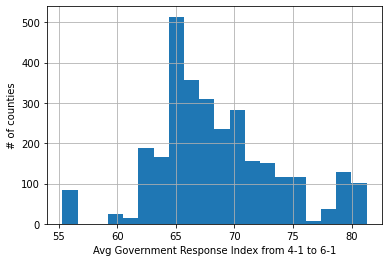

In [9]:
# let's see the distribution of government response scores
data['GovernmentResponseIndex'].hist(bins = 20)
plt.xlabel('Avg Government Response Index from 4-1 to 6-1')
plt.ylabel('# of counties')

As we can see from the histrogram above. The distribution of treatment (government response index) is pretty much normally distributed, so we don't need to do a log transformation or some other transformation.

In [10]:
data = data.dropna()

In [11]:
data.shape

(2994, 18)

# 1. calculate genearlized propensity score of each row

Caveat: does covariate of a county really predicts its dosage? covariate is property of a county but dosage is at the state level.

generalized propensity score is of course the generalization of our original definition of propensisty score.

remember the original definition of propensisty score is the Probability of a unit receiving the treatment given its covariates.

However, now we have not just one treatment but an infinite amount of treatments. So instead of having a Bernoulli distribution of treatment given covariates, we have a continuous distribution of treatments. Therefore our GPS is defined to be the **probability densisty** of taking the treatment value it received given the covariates.

For simplicity, let's assume the conditional distribution of treatment value given the covariate is gaussian, and the mean of gaussian linearly varies with the covariates (basically a generalized linear model).

In [12]:
%%R -i data
head(data)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [13]:
%%R
dosage_formula <- formula('GovernmentResponseIndex~Median.Household.Income+X..Rural+Population_y+political_diff+X..less.than.18.years.of.age+X..65.and.over+X..Asian+X..Black+X..Hispanic+X..Non.Hispanic.White')

In [14]:
%%R
# linear model of dosage/treatment/policy score based on covariates (median household income, etc)
dosage_model <- lm(formula = dosage_formula, data = data)

In [15]:
%%R
min(dosage_model$fitted)

[1] 60.42916


In [16]:
%%R
max(dosage_model$fitted)

[1] 78.41486


An important assumption in the calculation below is that we assume the **the standard deviation of the conditional distribution of treatments given covariates is the same as the unconditional distribution of treatments + all conditional distribution has the same standard deviation**

In [17]:
%%R
# calculate generalized propensity score of each row based
# off the conditional gaussian densisty
# dnorm calculates for density of normal distribution given
# x, mean of gaussian, standard devication of gaussian.
data$GPS = dnorm(data$GovernmentResponseIndex, mean = dosage_model$fitted,
                 sd = sd(data$GovernmentResponseIndex)) 

In [18]:
%%R
head(data)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [19]:
%%R
max(data$GPS)

[1] 0.07492357


In [20]:
%%R
min(data$GPS)

[1] 0.0003348365


First time I looked at the min and max GPS of all the rows I was surprised: the maximum GPS is only `0.07`, does that mean our GPS model is terrible? - max probability of a row receiving treatment is only `0.07`. Then I thought about that GPS means probability density and not probability, so I think we are good?

In [21]:
%%R
dnorm(0, mean = 0, sd = sd(data$GovernmentResponseIndex))

[1] 0.07492357


# 2. check covaraite balance

This is a part that I am quite confused about. First off, what does `standard effect size` really mean? When we were doing treatment effect size for a `0` and `1` treatment, we have some R libraries to do the calculation for us, so I didn't know what is going on. Now in this case for continuous treatment effect, we don't have a library that can calculate the covariate balance for us because it is a relatively new area of research.

The book **Practical Propensisty Score Methods Using R (Chapter 7)** proposes that we use standardized linear regression to assess whether we have good covariate balance after we calculated the GPS socres for each row.

The idea is as follows (or at least the way I understand it). We first stratify the GPS into a couple of stratas (4 or 5?) and then we fit linear regression for each covariate within each strata, and get the standardized coefficient of the covariate within each regression model. The covariate balance is achieved if the coeffciient doesn't change as much from one strata to another, and that each strata has relatively low coefficient in terms of absolute value (`< 0.1`)

Based on this interpretation, I will first create stratas for GPS variable, and select dataframes of each strata, pass those into R to do standardize linear regression (as python linear regression only supports normalization)

In [22]:
data_GPS = %R data

In [23]:
data_GPS.head()

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,GovernmentResponseIndex,GPS
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,69.134839,0.071629
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,69.134839,0.072059
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,69.134839,0.074463
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,69.134839,0.074398
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,69.134839,0.068484


In [24]:
# The following code creates unbalanced bins: GPS(0.06, 0.08) has 1777 data points
# data_GPS['strata_GPS'] = pd.cut(data_GPS['GPS'], bins = [0, 0.02, 0.04, 0.06, 0.08],
#                                 labels = ['strata_1', 'strata_2', 'strata_3', 'strata_4'])

# use qcut to create even bins.
data_GPS['strata_GPS'] = pd.qcut(data_GPS['GPS'], [0, .25, .5, .75, 1.],
                                 labels=['strata_1', 'strata_2', 'strata_3', 'strata_4'])

In [25]:
data_GPS.head()

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_at_home,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,GovernmentResponseIndex,GPS,strata_GPS
0,1.0,AL,Alabama,Autauga County,1001.0,0.050678,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3,69.134839,0.071629,strata_3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.050312,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1,69.134839,0.072059,strata_3
2,1.0,AL,Alabama,Barbour County,1005.0,0.007037,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6,69.134839,0.074463,strata_4
3,1.0,AL,Alabama,Bibb County,1007.0,0.011809,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6,69.134839,0.074398,strata_4
4,1.0,AL,Alabama,Blount County,1009.0,0.038890,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9,69.134839,0.068484,strata_3


In [26]:
data1 = data_GPS[data_GPS['strata_GPS'] == 'strata_1']
data2 = data_GPS[data_GPS['strata_GPS'] == 'strata_2']
data3 = data_GPS[data_GPS['strata_GPS'] == 'strata_3']
data4 = data_GPS[data_GPS['strata_GPS'] == 'strata_4']

In [27]:
# transport python dataframes into R
%%R -i data1
head(data1)

   state state_code State.Name                    cnamelong county_code
67     2         AK     Alaska       Anchorage Municipality        2020
68     2         AK     Alaska           Bethel Census Area        2050
69     2         AK     Alaska Fairbanks North Star Borough        2090
70     2         AK     Alaska      Juneau City and Borough        2110
71     2         AK     Alaska      Kenai Peninsula Borough        2122
72     2         AK     Alaska    Ketchikan Gateway Borough        2130
   diff_in_perc_at_home SIP. Median.Household.Income X..Rural Population_y
67         2.468819e-02    1                   82113      4.1       291538
68        -1.495898e-02    1                   44304     73.9        18216
69         1.564403e-02    1                   74268     30.9        98971
70         5.450379e-02    1                   79173     21.5        32113
71         3.006455e-03    1                   65439     79.3        58533
72         1.421355e-05    1                  

In [28]:
# transport python dataframes into R
%%R -i data2
head(data2)

   state state_code State.Name       cnamelong county_code diff_in_perc_at_home
82     4         AZ    Arizona   Apache County        4001         -0.018001618
88     4         AZ    Arizona   La Paz County        4012         -0.052749318
91     4         AZ    Arizona   Navajo County        4017          0.011353153
97     5         AR   Arkansas Arkansas County        5001          0.002032068
98     5         AR   Arkansas   Ashley County        5003          0.004201943
99     5         AR   Arkansas   Baxter County        5005         -0.000819999
   SIP. Median.Household.Income X..Rural Population_y political_diff
82    1                   33652     74.1        71818     0.36877646
88    1                   37350     56.3        21098    -0.41837356
91    1                   40650     54.1       110445    -0.07916067
97    0                   43887     34.7        17769    -0.30582131
98    0                   41127     51.7        20046    -0.36501806
99    0                   

In [29]:
# transport python dataframes into R
%%R -i data3
head(data3)

   state state_code State.Name       cnamelong county_code diff_in_perc_at_home
0      1         AL    Alabama  Autauga County        1001           0.05067828
1      1         AL    Alabama  Baldwin County        1003           0.05031198
4      1         AL    Alabama   Blount County        1009           0.03889032
6      1         AL    Alabama   Butler County        1013           0.01534992
10     1         AL    Alabama  Chilton County        1021           0.01758692
14     1         AL    Alabama Cleburne County        1029           0.01925057
   SIP. Median.Household.Income X..Rural Population_y political_diff
0     1                   59338     42.0        55601     -0.4947893
1     1                   57588     42.3       218022     -0.5778616
4     1                   50412     90.0        57840     -0.8138197
6     1                   37365     71.2        19680     -0.1352907
10    1                   47547     86.7        44153     -0.6660641
14    1                   

In [30]:
# transport python dataframes into R
%%R -i data4
head(data4)

  state state_code State.Name       cnamelong county_code diff_in_perc_at_home
2     1         AL    Alabama  Barbour County        1005          0.007036924
3     1         AL    Alabama     Bibb County        1007          0.011808926
5     1         AL    Alabama  Bullock County        1011         -0.009576347
7     1         AL    Alabama  Calhoun County        1015          0.017585134
8     1         AL    Alabama Chambers County        1017          0.002032661
9     1         AL    Alabama Cherokee County        1019          0.004307030
  SIP. Median.Household.Income X..Rural Population_y political_diff
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
5    1                   29267     51.4        10138     0.50861519
7    1                   45400     33.7       114277    -0.41383823
8    1                   39917     49.1        33615    -0.14806213
9    1                   42132     85.7

In [31]:
%%R
covariateNames <- c('Median.Household.Income', 'X..Rural', 'Population_y',
                    'political_diff', 'X..less.than.18.years.of.age',
                    'X..65.and.over', 'X..Asian', 'X..Black', 'X..Hispanic',
                    'X..Non.Hispanic.White')

In [32]:
%%R
# associate the string "data1" with dataframe data1.
assign("data1",data1)
assign("data2",data2)
assign("data3",data3)
assign("data4",data4)

In [33]:
%%R
stratas <- c('data1', 'data2', 'data3', 'data4')

In [34]:
%%R
linear_model = lm(scale(GovernmentResponseIndex)~scale(Median.Household.Income),
                  data = data1)

In [35]:
%%R
linear_model


Call:
lm(formula = scale(GovernmentResponseIndex) ~ scale(Median.Household.Income), 
    data = data1)

Coefficients:
                   (Intercept)  scale(Median.Household.Income)  
                    -3.091e-16                      -2.538e-02  



In [36]:
%%R
for (var in 1:length(covariateNames)) {
    print(paste("standard effect size for column ", covariateNames[var], sep = ''))
    for (data_in_strata in stratas) {
        linear_model_formula <- paste('scale(GovernmentResponseIndex)~scale(', covariateNames[var], ')', sep = '')
        linear_model = lm(linear_model_formula, data = get(data_in_strata))
        print(linear_model$coef[2])
    }
    # print()
}

[1] "standard effect size for column Median.Household.Income"
scale(Median.Household.Income) 
                   -0.02537864 
scale(Median.Household.Income) 
                     0.2658923 
scale(Median.Household.Income) 
                     0.2659327 
scale(Median.Household.Income) 
                     0.2965855 
[1] "standard effect size for column X..Rural"
scale(X..Rural) 
    -0.01716091 
scale(X..Rural) 
     -0.2375581 
scale(X..Rural) 
     -0.2667027 
scale(X..Rural) 
     -0.2076842 
[1] "standard effect size for column Population_y"
scale(Population_y) 
        0.001087041 
scale(Population_y) 
           0.233637 
scale(Population_y) 
          0.3366562 
scale(Population_y) 
          0.2694435 
[1] "standard effect size for column political_diff"
scale(political_diff) 
           0.06840666 
scale(political_diff) 
             0.270053 
scale(political_diff) 
            0.5623739 
scale(political_diff) 
            0.7057137 
[1] "standard effect size for column X..les

If I did this right, then we can see our GPS model is really bad because a lot of columns have `>0.1` standard effect size.

# 3. model outcome in terms of treatment dosage + GPS

In [37]:
%%R
design <- svydesign(id=~1,weights=~1,data =data)
# model quadratic terms and interaction terms.
modelOutcome <- svyglm(formula = 'diff_in_perc_at_home~GovernmentResponseIndex+I(GovernmentResponseIndex^2) + GPS + I(GPS^2) + GovernmentResponseIndex:GPS', design = design) 

# 4. plot dosage response function

In [38]:
%%R
quantile(data$GovernmentResponseIndex, probs = seq(0.00, 1, 0.1))

 [1] 55.30871 62.55806 65.02290 65.57452 66.53452 67.63661 69.13484 70.27032
 [9] 72.97645 74.93065 81.29097


In [39]:
%%R
head(data.frame(GovernmentResponseIndex=70, GPS = data$GPS), 10)

   GovernmentResponseIndex        GPS
1                       70 0.07162899
2                       70 0.07205904
3                       70 0.07446314
4                       70 0.07439824
5                       70 0.06848431
6                       70 0.07353232
7                       70 0.07233322
8                       70 0.07358821
9                       70 0.07444013
10                      70 0.07308535


In [40]:
%%R
# new empty dataframe that contains the effect sizes for each dosage
all.effects <- data.frame()
# new empty dataframe for standard errors for each estimate
se <- data.frame()
for (dose in quantile(data$GovernmentResponseIndex, probs = seq(0.00, 1, 0.1))) {
    # we are predicting all row's effect based on its GPS and the current dosage size
    # in the loop. Averaging over those effect to be the effect size at the current
    # dosage level.
    effects <- predict(modelOutcome, type = 'response', vcov = T,
                       newdata = data.frame(GovernmentResponseIndex=dose, GPS = data$GPS))
    # svycontrast calculate the effect size for us.
    effect <- svycontrast(effects, rep(1/nrow(data), nrow(data)) )
    # rbind add rows to a dataframe in R.
    all.effects <- rbind(all.effects, effect)
    # SE() of svycontrast object returns the estimated standard error
    se <- rbind(se, SE(effect)[1])
} 

In [41]:
%%R
all.effects

   X0.00996308829104974
1           0.009963088
2           0.013795090
3           0.018672620
4           0.020012583
5           0.022561233
6           0.025826412
7           0.030846820
8           0.035098176
9           0.046782189
10          0.056579258
11          0.096360795


In [42]:
%%R
se

   X0.00762490557788741
1           0.007624906
2           0.001289081
3           0.001315283
4           0.001399095
5           0.001529613
6           0.001623962
7           0.001637007
8           0.001576425
9           0.001577893
10          0.002276086
11          0.008636191


In [43]:
%%R
doseResponses <- data.frame(percentile = seq(0, 100, 10),
                            GovernmentResponseIndex = quantile(data$GovernmentResponseIndex,
                                                               probs = seq(0.00, 1, 0.1)),
                            all.effects, se)
names(doseResponses)[3] <- "mean_diff_perc_stay_at_home"
names(doseResponses)[4] <- "standard_error"
doseResponses$lowerCL <- with(doseResponses, mean_diff_perc_stay_at_home - 1.96*standard_error)
doseResponses$upperCL <- with(doseResponses, mean_diff_perc_stay_at_home + 1.96*standard_error)

In [44]:
%%R
doseResponses

     percentile GovernmentResponseIndex mean_diff_perc_stay_at_home
0%            0                55.30871                 0.009963088
10%          10                62.55806                 0.013795090
20%          20                65.02290                 0.018672620
30%          30                65.57452                 0.020012583
40%          40                66.53452                 0.022561233
50%          50                67.63661                 0.025826412
60%          60                69.13484                 0.030846820
70%          70                70.27032                 0.035098176
80%          80                72.97645                 0.046782189
90%          90                74.93065                 0.056579258
100%        100                81.29097                 0.096360795
     standard_error      lowerCL    upperCL
0%      0.007624906 -0.004981727 0.02490790
10%     0.001289081  0.011268491 0.01632169
20%     0.001315283  0.016094665 0.02125057
30%     

In [45]:
doseResponses = %R doseResponses

In [46]:
doseResponses

,percentile,GovernmentResponseIndex,mean_diff_perc_stay_at_home,standard_error,lowerCL,upperCL
0%,0.0,55.308710,0.009963,0.007625,-0.004982,0.024908
10%,10.0,62.558065,0.013795,0.001289,0.011268,0.016322
20%,20.0,65.022903,0.018673,0.001315,0.016095,0.021251
30%,30.0,65.574516,0.020013,0.001399,0.017270,0.022755
40%,40.0,66.534516,0.022561,0.001530,0.019563,0.025559
50%,50.0,67.636613,0.025826,0.001624,0.022643,0.029009
60%,60.0,69.134839,0.030847,0.001637,0.027638,0.034055
70%,70.0,70.270323,0.035098,0.001576,0.032008,0.038188
80%,80.0,72.976452,0.046782,0.001578,0.043690,0.049875
90%,90.0,74.930645,0.056579,0.002276,0.052118,0.061040


plot dose response function with confidence intervals.

Text(0, 0.5, '% change in percentage stay at home')

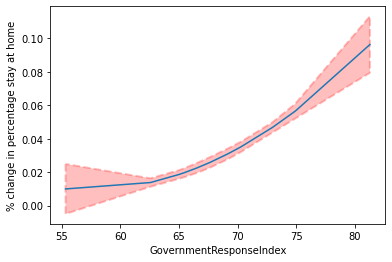

In [47]:
plt.plot(doseResponses['GovernmentResponseIndex'], doseResponses['mean_diff_perc_stay_at_home'])
plt.fill_between(doseResponses['GovernmentResponseIndex'],
                 doseResponses['lowerCL'], doseResponses['upperCL'], color='r', alpha=.25, linestyle = 'dashed', linewidth = 2)
plt.xlabel('GovernmentResponseIndex')
plt.ylabel('% change in percentage stay at home')

# Conclusion 1

This is a rough notebook of estimating continuous treatment effect by making a model of outcome in terms of GPS and the dosage with a quadratic regression model. Can't say for sure I am super confident this method is right, because I am unsure of a lot of R functions such as `svycontrast` and exactly what it does. Also the covariate balance seems very bad in my examination approach.

Will polish this method and use **inverse probability weighing** in the future to do better in covariate balance.

# Inverse probability weighting

Robins et al. (2000) proposed inverse probability weighting to get rid of selection bias. The weight in this continuous treatment case is 
$w_i = \frac{f_Z(z_i)}{f_{Z|X}(z_i|x_i)}$, where $z_i$ means the treatment dosage $i$-th individual receives, $x_i$ denotes his covariates. The formula's denominator is just the generalized propensisty score we calculated before, and the nominator is marginal densisty of treatment dosage at a particular value.

## calculate inverse probability weight.

In [48]:
%%R
# for each row, add another entry of that row's densisty according to that row's
# GovernmentResponseIndex (treatment dosage), based on the distribution of GovernmentResponseIndex
# we assume here the distribution of GovernmentResponseIndex is gaussian, which is
# not far away from the truth.
data$numerator <- with(data,  dnorm(GovernmentResponseIndex, mean = mean(GovernmentResponseIndex),
                                    sd = sd(GovernmentResponseIndex)))

In [49]:
%%R
data$IPW <- with(data, numerator/GPS)

In [50]:
%%R
head(data)

  state state_code State.Name      cnamelong county_code diff_in_perc_at_home
0     1         AL    Alabama Autauga County        1001          0.050678282
1     1         AL    Alabama Baldwin County        1003          0.050311979
2     1         AL    Alabama Barbour County        1005          0.007036924
3     1         AL    Alabama    Bibb County        1007          0.011808926
4     1         AL    Alabama  Blount County        1009          0.038890321
5     1         AL    Alabama Bullock County        1011         -0.009576347
  SIP. Median.Household.Income X..Rural Population_y political_diff
0    1                   59338     42.0        55601    -0.49478934
1    1                   57588     42.3       218022    -0.57786162
2    1                   34382     67.8        24881    -0.05611165
3    1                   46064     68.4        22400    -0.55544124
4    1                   50412     90.0        57840    -0.81381973
5    1                   29267     51.4       

In [51]:
%%R
print(summary(data$IPW))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.07861  0.86221  0.98158  1.00568  1.04462 20.47321 


We can see that the maxium weight we created is `20`, which is not of great concern here. Again, there is not a literature right now about what kind of weights are extremely high, but my general feelings is if it is above `50` or `100` then it is insanely high. 

## Covariate balance check again.

In [52]:
%%R
designIPW <- svydesign(ids=~1, weights=~IPW, data=data)

In [53]:
%%R
formula <- paste('GovernmentResponseIndex~', covariateNames[1], sep = '')

In [54]:
%%R
# design in the arguments is our design object without IPW
glm <- svyglm(formula,design)

In [55]:
%%R
print(coef(glm))

            (Intercept) Median.Household.Income 
           6.628442e+01            4.249972e-05 


In [56]:
%%R
# -1 means drop the first element in array in R.
print(coef(glm)[-1])

Median.Household.Income 
           4.249972e-05 


In [57]:
%%R
balanceTableIPW <- data.frame()
for (index in 1:length(covariateNames)) {
    balanceFormula <- paste('GovernmentResponseIndex~', covariateNames[index], sep = '')
    maxEffBaseline <- max(abs(coef(svyglm(balanceFormula, design))[-1]))
    maxEffIPW <- max(abs(coef(svyglm(balanceFormula, designIPW))[-1]))
    # add these two entries to our table.
    balanceTableIPW <- rbind(balanceTableIPW,c(index, maxEffBaseline, maxEffIPW))
}

In [58]:
%%R
balanceTableIPW

   X1 X4.24997162238739e.05 X3.5977298051223e.06
1   1          4.249972e-05         3.597730e-06
2   2          1.953963e-02         1.715260e-03
3   3          1.732383e-06         2.393856e-07
4   4          4.001141e+00         1.110030e+00
5   5          3.559090e-01         7.056735e-02
6   6          2.394763e-02         5.185418e-02
7   7          2.803195e-01         7.182487e-02
8   8          1.386919e-02         1.288771e-03
9   9          1.293072e-03         1.135625e-02
10 10          4.363113e-03         1.833805e-02


In [59]:
%%R
names(balanceTableIPW) <- c('variable', 'coefWithoutIPW', 'coefIPW')

In [60]:
%%R
balanceTableIPW

   variable coefWithoutIPW      coefIPW
1         1   4.249972e-05 3.597730e-06
2         2   1.953963e-02 1.715260e-03
3         3   1.732383e-06 2.393856e-07
4         4   4.001141e+00 1.110030e+00
5         5   3.559090e-01 7.056735e-02
6         6   2.394763e-02 5.185418e-02
7         7   2.803195e-01 7.182487e-02
8         8   1.386919e-02 1.288771e-03
9         9   1.293072e-03 1.135625e-02
10       10   4.363113e-03 1.833805e-02


In [61]:
%%R
balanceTableIPW$coefWithoutIPW <- balanceTableIPW$coefWithoutIPW / sqrt(coef(svyvar(~GovernmentResponseIndex, design)))

In [62]:
%%R
balanceTableIPW$coefIPW <- balanceTableIPW$coefIPW / sqrt(coef(svyvar(~GovernmentResponseIndex,designIPW)))

In [63]:
%%R
balanceTableIPW$variable <- covariateNames 

In [64]:
%%R
balanceTableIPW

                       variable coefWithoutIPW      coefIPW
1       Median.Household.Income   7.981682e-06 7.020283e-07
2                      X..Rural   3.669651e-03 3.347002e-04
3                  Population_y   3.253512e-07 4.671153e-08
4                political_diff   7.514365e-01 2.166011e-01
5  X..less.than.18.years.of.age   6.684167e-02 1.376987e-02
6                X..65.and.over   4.497497e-03 1.011835e-02
7                      X..Asian   5.264555e-02 1.401525e-02
8                      X..Black   2.604712e-03 2.514791e-04
9                   X..Hispanic   2.428460e-04 2.215956e-03
10        X..Non.Hispanic.White   8.194167e-04 3.578320e-03


Seeing from this table our original method is not that bad, as `coefWithoutIPW` are in the order of `e-02`, which are less than `0.1`, except for `political_diff`, which is `0.7`. our `coefIPW` improves that into `0.2`

Am I doing something wrong? The standard effect size shouldn't be this small!

## estimation of ATE

We can estimate the average treatment effect in the continuous case by fitting a regression model to $y_i = \beta_0 + \gamma Z_i + \epsilon_i$, where $Z_i$ is the dosage (treatment), and $y_i$ is the the response variable we want (in this case difference in people's behavioral change). So then $\gamma$ is the ATE we will report.

It is noted in the book that if we have some covariates that didn't achieve the covariate balance (standard effect size $> 0.1$), then we need to include those covaraites and their interaction with the treatment dosage into our regression model.

In our case the `political_diff` didn't achieve great balance, so we will include that in our regression model as follows:
$$y_i = \beta_0 + \gamma Z_i + \beta_1 X + \beta_2 X_i Z_i + \epsilon_i$$,
Where $X_i$ is the `political_diff` covaraite.

**We also need to center the covariate to make ATE result interpretable** 

In [65]:
%%R
# center political_diff, scale = F means we don't make the whole
# thing unit standard deviation, we only center the distribution.
data$political_diff <- scale(data$political_diff, scale = F)

In [66]:
%%R
# recreate designIPW object because political_diff has changed.
designIPW <- svydesign(ids=~1,weights=~IPW,data=data)

In [67]:
%%R
outcomeModelDR <- svyglm(formula = diff_in_perc_at_home~GovernmentResponseIndex + 
                         political_diff + political_diff:GovernmentResponseIndex,
                         design = designIPW, family=gaussian) 

In [68]:
%%R
summary(outcomeModelDR)


Call:
svyglm(formula = diff_in_perc_at_home ~ GovernmentResponseIndex + 
    political_diff + political_diff:GovernmentResponseIndex, 
    design = designIPW, family = gaussian)

Survey design:
svydesign(ids = ~1, weights = ~IPW, data = data)

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                             3.455e-02  1.363e-02   2.536  0.01127
GovernmentResponseIndex                -7.837e-05  2.034e-04  -0.385  0.70010
political_diff                         -1.103e-01  4.966e-02  -2.220  0.02650
GovernmentResponseIndex:political_diff  2.336e-03  7.298e-04   3.201  0.00139
                                         
(Intercept)                            * 
GovernmentResponseIndex                  
political_diff                         * 
GovernmentResponseIndex:political_diff **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.001431601)

Numbe

This looks bad because the p score of `GovernmentResponseIndex` is `0.7`, which means it is not statistically significant. And the coefficient of `GovernmentResponseIndex` in the regression model is so low... Am I doing something wrong???? 

# Conclusion 2

- Really think I am doing something wrong with both the covariate balance check and the ATE estimate
- current ATE with IPW is really small and statistically unsignificant.
- current covariate balance is really good (in the order of `e-2, e-3`) except for `political_diff` variable (`0.2`)